# Fifth exercise (Chapter 7)¶

Chapter 7 is about regularization, in this assignment we will implement various forms of regularization for MLP's. 

* L2 regularization
* Dropout
* Early stopping

In the following code block, all necessary imports are provided as well as the data generators. You can use your MLP implementation from the previous assignment or the reference implementation attached. In this reference implementations, there are some slight differences with the network that was provided for the previous example, most notably: 

* The cost function now also has an update function integrated
* The data format is standardized for all sets (train, test and validation)

## Data

We will make use of the digits dataset, standard packed in sklearn. It contains a similar classification task as MNIST, however the images are smaller (64 pixels), making experimenting with it faster. 

For your convenience, a convert function has been provided to convert the dataset into the format that the reference network accepts. 

In [3]:
%matplotlib inline
import numpy as np
# import scipy.stats
import random
from sklearn.datasets import load_digits
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

In [4]:
def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

X, y = load_digits(return_X_y=True)
testsize = len(X) / 10
validsize = len(X) / 10

train_indices = np.arange(len(X) - testsize - validsize, dtype=np.int)
valid_indices = np.arange(len(train_indices), len(X) - testsize, dtype=np.int)
test_indices = np.arange(len(train_indices) + len(valid_indices), len(X), dtype=np.int)

train_set = [(np.reshape(X[idx], (len(X[idx]), 1)), vectorized_result(y[idx])) for idx in train_indices]
valid_set = [(np.reshape(X[idx], (len(X[idx]), 1)), vectorized_result(y[idx])) for idx in valid_indices]
test_set  = [(np.reshape(X[idx], (len(X[idx]), 1)), vectorized_result(y[idx])) for idx in test_indices]

num_features = len(X[0])
num_classes = 10

## Reference Network

Replace the cell below with your own network from exercise 6. Make sure that it doesn't deviate to much from the reference implementation.

In [7]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))


def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def Generate_DropOut_Mask(p_DropOut, sizes):   # p_DropOut is Tuple (p_input, p_hidden)
    # Create Mask (List of arrays) for randomly switch on/off nodes - dim = sizes of Network as defined in Network init
    mu = [] 
    for i, size in enumerate(sizes):     # sum of squared of each single weight parameter --> iterate through layers
        if p_DropOut != None:
            if i == 0:                   # DropOut[0] if input layer (i==0), 
                mask = bernoulli.rvs(p_DropOut[0], size=size)  
            elif i < len(sizes) - 1:         # all hidden layers p_DropOut(1) = p_hidden 
                mask = bernoulli.rvs(p_DropOut[1], size=size)
            else:
                mask = np.ones(size, dtype=int)    # output layer always one --> no dropout
            # set_trace()
        else: 
            mask = np.ones(size, dtype=int) # all one, mask has no effect
        mu.append(mask)  
    # set_trace()
    return mu

class QuadraticCost(object):
    @staticmethod
    def fn(a, y, weights = []):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.
        
        a is an array (size (num_classes, 1)) the activations of the output_layer,
        y is an array (same size) with the class label.
        """
        return 0.5 * np.linalg.norm(a - y) ** 2

    @staticmethod
    def delta(z, a, y):
        """Return the derivative of the cost function wrt z.
           Recall that a=sigmoid(z).
           
           z, a and y are arrays of shape (num_classes, 1)
        """
        return (a - y) * sigmoid_prime(z)

    @staticmethod
    def update(w, nw, eta, size):
        """Does a single gradient step. 
        
        w and nw are arrays with size corresponding to the weights vector; 
        eta and size are scalars. 
        """
        return w - (eta / size) * nw


class RidgeCost(object):
    
    def __init__(self, alpha=0):
        self.alpha = alpha
    
    # @staticmethod
    def fn(self, a, y, weights):

        squared_weights = 0
        for w in weights:      # sum of squared of each single weight parameter --> iterate through layers
            squared_weights += np.sum(w**2)   # sum of elementwise squared matrices

        return 0.5 * np.linalg.norm(a - y) ** 2 + (self.alpha/2) * squared_weights

    def delta(self, z, a, y):
        """Return the derivative of the cost function wrt z.
           Recall that a=sigmoid(z).
           
           z, a and y are arrays of shape (num_classes, 1)
        """
        return (a - y) * sigmoid_prime(z)  

    # @staticmethod
    def update(self, w, nw, eta, size):
        """Does a single gradient step. 
        
        w and nw are arrays with size corresponding to the weights vector; 
        eta and size are scalars. 
        """
        return (1 - eta*self.alpha) * w - (eta / size) * nw
    

class Network(object):
    def __init__(self, sizes, cost=QuadraticCost, p_DropOut=None, EarlyStop=None):  
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        set_trace()
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.cost = cost
        self.p_DropOut = p_DropOut # Tuple (p_input, p_hidden)
        self.EarlyStop = EarlyStop
        self.best_epoch = 0        # number of epochs after which best cost was encountered at early stopping

    # in case of dropout: k is number of masks to be generated in order to approximate the resulting distribution 
    # of the predictions by sampling (7.5.2). 
    # If k = 1 rescale weights according to "weight scaling inference rule", k = 0 means no dropuot
    def feedforward(self, a):  
        """Return the output of the network if ``a`` is input."""

        if self.p_DropOut != None:    # sample k cases for DropOut mask
            k = self.p_DropOut[2]             
            if k == 1:     # rescale weights according to "weight scaling inference rule" 
                for b, w in zip(self.biases, self.weights):
                    w_next = w  * self.p_DropOut[1] 
                    a = sigmoid(np.dot(w_next, a) + b)            
            else:   # k>1
                a_cum = 0
                for i in range(k):
                    next_a = a
                    mu = Generate_DropOut_Mask(self.p_DropOut, self.sizes)
                    for b, w, m in zip(self.biases, self.weights, mu[1:]):
                        z = np.dot(w, next_a) + b    
                        z[:,0] = z[:,0] * m.astype(np.float32) 
                        next_a = sigmoid(z)
                    a_cum += next_a
                a = a_cum / k
                
        else:    # no DropOut
            for b, w in zip(self.biases, self.weights):
                a = sigmoid(np.dot(w, a) + b)
            
        return a
    
    def SGD(self, training_data, max_epochs, mini_batch_size, eta,
            validation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs. Here, x represents an array with dimensions 
        (num_attributes, 1); y is an array of size (num_classes, 1) 
        The other non-optional parameters are self-explanatory.  
        If ``test_data`` is provided (same format as training_data) 
        then the network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""

        if validation_data: n_data = len(validation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        
        epoch = 0           
        if self.EarlyStop != None:    # initialise early stopping parameters
            steps_per_eval = self.EarlyStop[0]
            patience = self.EarlyStop[1]
            j = 0        # counter for the batches of epochs performed before next evaluation
            best_error = 1.000
            best_weights = self.weights  # initialise best weights
            best_biases = self.biases
            best_epoch = epoch

        _continue = True
        while _continue:
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k + mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            epoch += 1

            if self.EarlyStop != None:
                if epoch % steps_per_eval == 0:
                    assert validation_data != None
                    this_error = self.total_cost(validation_data)
                    if this_error < best_error:
                        j = 0       # start counting "batches during patience" from zero 
                        best_weights = self.weights   # store parameters 
                        best_biases = self.biases
                        best_epoch = epoch
                        best_error = this_error
                    else:
                        j += 1
                if j >= patience:
                    self.best_epoch = best_epoch   # update class variable (remains 0, if no minimum encountered)
                    _continue = False

            if epoch >= max_epochs:
                _continue = False
            
            if epoch % 10 == 0:
                
                print("Epoch {} complete".format(epoch))

                if monitor_training_cost:
                    cost = self.total_cost(training_data)
                    training_cost.append(cost)
                    print("Cost on training data: {}".format(cost))
                if monitor_training_accuracy:
                    accuracy = self.accuracy(training_data)
                    training_accuracy.append(accuracy)
                    print("Accuracy on training data: {} / {}".format(
                        accuracy, n))
                if monitor_evaluation_cost:
                    cost = self.total_cost(validation_data)
                    evaluation_cost.append(cost)
                    print("Cost on evaluation data: {}".format(cost))
                if monitor_evaluation_accuracy:
                    accuracy = self.accuracy(validation_data)
                    evaluation_accuracy.append(accuracy)
                    print("Accuracy on evaluation data: {} / {}".format(
                        self.accuracy(validation_data), n_data))

        if self.EarlyStop != None:
            self.weights = best_weights
            self.biases = best_biases
            print("\n best value found at epoch {}".format(self.best_epoch))
            
        return training_cost, training_accuracy, evaluation_cost, \
               evaluation_accuracy, self.best_epoch     
                    
    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)`` (similar to 
        the data structure defined in SGD) and ``eta`` is the learning 
        rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]   # initialise with zero
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        mu = Generate_DropOut_Mask(self.p_DropOut, self.sizes) # use one DropOut mask per mini batch
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y, mu)    # delta_nabla_w are gradients
            # sum up / accumulate nabla_bs of all samples in Mini-Batch
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]   
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        # perform update step with accumulated gradients (mean is taken inside update function)
        self.nabla_w = nabla_w
        self.weights = [self.cost.update(w, nw, eta, len(mini_batch)) for w, nw in zip(self.weights, nabla_w)]
        self.biases = [self.cost.update(b, nb, eta, len(mini_batch)) for b, nb in zip(self.biases, nabla_b)]
        
    def backprop(self, x, y, mu):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward for training: here apply DropOut mask
        activation = x
        activation[:,0] = activation[:,0] * mu[0]   # apply mu on input layer
        activations = [activation]  # list to store all the activations, layer by layer
        zs = []  # list to store all the z vectors, layer by layer (A in Boedecker notation)
        for b, w, m in zip(self.biases, self.weights, mu[1:]):  # run through mu list from second layer (= first hidden layer, mu[0] is first one is for input X)
            z = np.dot(w, activation) + b    
            activation = sigmoid(z)
            if self.p_DropOut != None:
                layer_mask = m.astype(np.float32)
                activation[:,0] = activation[:,0] * layer_mask            
            zs.append(z)
            activations.append(activation)
        # backward pass                                       # activations are Z in Boed- notation
        delta = self.cost.delta(zs[-1], activations[-1], y)   # dL/dz = h'  (dL/dA in Boedecker notation)
        delta[:,0] = delta[:,0] * mu[-1]                      # does nothing, as ones are stored in last layer of mask
        nabla_b[-1] = delta                                   # dL/db = dL/dz   
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())   # dL/dw = A dot dL/dZ 
        # Note that the variable l in the loop below is used in the following way:
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]      # a1 bei Boedecker
            sp = sigmoid_prime(z)    # h'(a1)
            # start with (first loop, counting from l=2) -l+1 = -2+1 = -1 = last layer downwards until first hidden
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp  # Boed dL/dA0 = (dL/dA1 x w1).T * h'(A)
            if self.p_DropOut != None:
                layer_mask = mu[-l].astype(np.float32)
                delta[:,0] = delta[:,0] * layer_mask    
            nabla_b[-l] = delta                                           # Boed dL/db = dL/dA
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())  # Boed dL/dW = Z0.T x dL/dA0
        self.activations = activations
        return (nabla_b, nabla_w)

    def accuracy(self, data):
        """Return the number of inputs in ``data`` for which the neural
        network outputs the correct result. The neural network's
        output is assumed to be the index of whichever neuron in the
        final layer has the highest activation.
        The flag ``convert`` should be set to False if the data set is
        validation or test data (the usual case), and to True if the
        data set is the training data. The need for this flag arises
        due to differences in the way the results ``y`` are
        represented in the different data sets.  In particular, it
        flags whether we need to convert between the different
        representations.  It may seem strange to use different
        representations for the different data sets.  Why not use the
        same representation for all three data sets?  It's done for
        efficiency reasons -- the program usually evaluates the cost
        on the training data and the accuracy on other data sets.
        These are different types of computations, and using different
        representations speeds things up.
        """
        results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data):
        """Return the total cost for the data set ``data``.  The flag
        ``convert`` should be set to False if the data set is the
        training data (the usual case), and to True if the data set is
        the validation or test data.  See comments on the similar (but
        reversed) convention for the ``accuracy`` method, above.
        """
        cost = 0.0
        for x, y in data:
            y_pred = self.feedforward(x)   # a = y_pred
            cost += self.cost.fn(y_pred, y, self.weights) / len(data)
        return cost


## L2 Regularization

Implement L2 regularization using the equations 7.1 - 7.5, by creating a new cost class (containing hyperparameter alpha), containing the same functions as QuadraticCost, i.e., fn, delta and update. Plot how test performance varies for various values of alpha. 

In [82]:
layers = [num_features, 50, 50, 50, num_classes]
e_accuracies=[]
alphas = [0.00,0.0001,0.001,0.003,0.01,0.1]
# net = Network(layers, cost=r_cost)
for alpha in alphas:
    net = Network(layers, cost=RidgeCost(alpha = alpha))
    t_cost, t_accuracy, e_cost, e_accuracy, best_epoch = net.SGD(train_set, 300, 50, 0.1,
                validation_data=test_set,
                monitor_evaluation_cost=True,
                monitor_evaluation_accuracy=True,
                monitor_training_cost=True,
                monitor_training_accuracy=True)   # orig epochs 300
    e_accuracies.append(e_accuracy)
    print("alpha = {} evaluated".format(alpha))

Epoch 10 complete
Cost on training data: 0.4447257079581535
Accuracy on training data: 363 / 1438
Cost on evaluation data: 0.4403441363573457
Accuracy on evaluation data: 50 / 179
Epoch 20 complete
Cost on training data: 0.39596126567276185
Accuracy on training data: 529 / 1438
Cost on evaluation data: 0.39857733551627844
Accuracy on evaluation data: 72 / 179
Epoch 30 complete
Cost on training data: 0.3639357326504412
Accuracy on training data: 615 / 1438
Cost on evaluation data: 0.37261323393297713
Accuracy on evaluation data: 82 / 179
Epoch 40 complete
Cost on training data: 0.33920747802399914
Accuracy on training data: 695 / 1438
Cost on evaluation data: 0.35550135132750044
Accuracy on evaluation data: 80 / 179
Epoch 50 complete
Cost on training data: 0.3178442099848498
Accuracy on training data: 768 / 1438
Cost on evaluation data: 0.339648916672647
Accuracy on evaluation data: 91 / 179
Epoch 60 complete
Cost on training data: 0.2975777477445237
Accuracy on training data: 824 / 143

Epoch 160 complete
Cost on training data: 0.6218427621503261
Accuracy on training data: 993 / 1438
Cost on evaluation data: 0.6702643584055333
Accuracy on evaluation data: 103 / 179
Epoch 170 complete
Cost on training data: 0.6113045085518714
Accuracy on training data: 1002 / 1438
Cost on evaluation data: 0.6628359715237447
Accuracy on evaluation data: 105 / 179
Epoch 180 complete
Cost on training data: 0.6016824893711877
Accuracy on training data: 1016 / 1438
Cost on evaluation data: 0.6574573985475878
Accuracy on evaluation data: 105 / 179
Epoch 190 complete
Cost on training data: 0.5932192679802214
Accuracy on training data: 1021 / 1438
Cost on evaluation data: 0.6518404077893657
Accuracy on evaluation data: 106 / 179
Epoch 200 complete
Cost on training data: 0.5855942021416318
Accuracy on training data: 1026 / 1438
Cost on evaluation data: 0.6454869810086651
Accuracy on evaluation data: 108 / 179
Epoch 210 complete
Cost on training data: 0.5785636806160243
Accuracy on training data

Epoch 10 complete
Cost on training data: 11.649755726059528
Accuracy on training data: 334 / 1438
Cost on evaluation data: 11.65662778433178
Accuracy on evaluation data: 42 / 179
Epoch 20 complete
Cost on training data: 9.798918904022273
Accuracy on training data: 588 / 1438
Cost on evaluation data: 9.81037393300422
Accuracy on evaluation data: 72 / 179
Epoch 30 complete
Cost on training data: 8.253221978336025
Accuracy on training data: 778 / 1438
Cost on evaluation data: 8.26978303045743
Accuracy on evaluation data: 91 / 179
Epoch 40 complete
Cost on training data: 6.967432691039528
Accuracy on training data: 913 / 1438
Cost on evaluation data: 6.979940794500405
Accuracy on evaluation data: 110 / 179
Epoch 50 complete
Cost on training data: 5.890825720960313
Accuracy on training data: 1033 / 1438
Cost on evaluation data: 5.903500180936576
Accuracy on evaluation data: 118 / 179
Epoch 60 complete
Cost on training data: 4.992570397984862
Accuracy on training data: 1113 / 1438
Cost on ev

Accuracy on training data: 146 / 1438
Cost on evaluation data: 0.4683505123526756
Accuracy on evaluation data: 18 / 179
Epoch 170 complete
Cost on training data: 0.4663661228662796
Accuracy on training data: 146 / 1438
Cost on evaluation data: 0.4663472893649756
Accuracy on evaluation data: 18 / 179
Epoch 180 complete
Cost on training data: 0.4652493927368722
Accuracy on training data: 146 / 1438
Cost on evaluation data: 0.46526238437075945
Accuracy on evaluation data: 18 / 179
Epoch 190 complete
Cost on training data: 0.46461294330622616
Accuracy on training data: 145 / 1438
Cost on evaluation data: 0.46459667269269955
Accuracy on evaluation data: 17 / 179
Epoch 200 complete
Cost on training data: 0.4642527877252986
Accuracy on training data: 145 / 1438
Cost on evaluation data: 0.4642605539801151
Accuracy on evaluation data: 17 / 179
Epoch 210 complete
Cost on training data: 0.4640494111651824
Accuracy on training data: 145 / 1438
Cost on evaluation data: 0.46403602303670555
Accuracy 

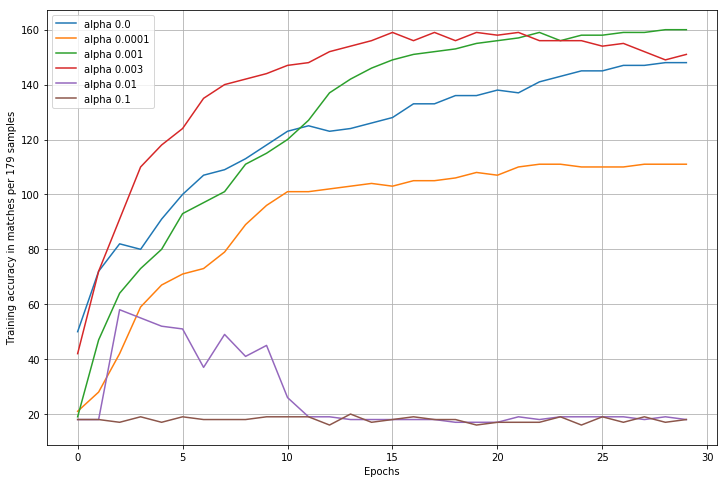

In [83]:
plt.figure(figsize=(12, 8))
for i, e_accuracy in enumerate(e_accuracies):
    # print(e_accuracy)
    plt.plot(e_accuracy, label="alpha {}".format(alphas[i]))
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Training accuracy in matches per 179 samples")
plt.legend(loc='best')

Results:

The behaviour at alpha = 0 (meaning no regularisation at all) is strange, but was observed from time to time when experimenting with the network: it does not start to learn, and seems "frozen". Eventually the randomly chosen starting point in parameter space was a bad one, that does not allow the gradients to improve.

The failure in learning with the high alphas can be understood: the weights are suppressed too strongly by the regularisation term, and thus cannot move enough to approach regions of better model capacity --> underfitting.

The best performance is reached with an alpha of approximately 0.001.

Its somewhat surprising, that the learning progress during the first 5 epochs is faster with the stronger regularisation. 

## Dropout

Implement dropout as explained in 7.12. Create a function generateMask(p_input, p_hidden) that generates a list of l arrays, each element in l being an array of size (layer_size, 1). Each element of the array on the first level is 1 with probability p_input. Each element of the array on the last level (output layer) is 1. Each element of the other arrays is 1 with probability p_hidden. For this you can use the distribution scipy.stats.bernoulli. Add hyperparameters p_input and p_hidden to the network. 

Inference occurs as presented in equation 7.52. Plot how the test performance varies for various values of k. 

In [8]:
layers = [num_features, 50, 50, 50, num_classes]
# net = Network(layers, cost=RidgeCost(alpha = 0.001), p_DropOut = [0.8, 0.5, 10])   # input / hidden unit
# net = Network(layers, cost=QuadraticCost, p_DropOut = None)   # input / hidden unit / k
net = Network(layers, cost=QuadraticCost, p_DropOut = [0.8, 0.5, 1])   # input / hidden unit / k
# net = Network(layers)   # input / hidden unit
# net = Network(layers, p_DropOut = None)   # input / hidden unit
t_cost, t_accuracy, e_cost, e_accuracy, best_epoch = net.SGD(train_set, 400, 50, 0.2, validation_data=test_set,
                monitor_evaluation_cost=True,
                monitor_evaluation_accuracy=True,
                monitor_training_cost=True,
                monitor_training_accuracy=True)   # orig epochs 300   

> <ipython-input-7-5170797a72e6>(103)__init__()
    101         ever used in computing the outputs from later layers."""
    102         set_trace()
--> 103         self.num_layers = len(sizes)
    104         self.sizes = sizes
    105         self.biases = [np.random.randn(y, 1) for y in sizes[1:]]

ipdb> sizes
[64, 50, 50, 50, 10]
ipdb> sizes[1:]
[50, 50, 50, 10]
ipdb> sizes[:-1]
[64, 50, 50, 50]
ipdb> sizes[-1]
10
ipdb> sizes[-1:]
[10]
ipdb> sizes[-2]
50
ipdb> sizes[:-2]
[64, 50, 50]
ipdb> sizes[:]
[64, 50, 50, 50, 10]
ipdb> sizes[-]
*** SyntaxError: invalid syntax
ipdb> sizes[:-1]
[64, 50, 50, 50]
ipdb> sizes[:1]
[64]
ipdb> sizes[1:]
[50, 50, 50, 10]
ipdb> sizes[::-1]
[10, 50, 50, 50, 64]
ipdb> sizes[-1:]
[10]
ipdb> sizes[-1::]
[10]
ipdb> quit


BdbQuit: 

## Observations DropOut

When running, the cost on the training as well as the evaluation set decreases fast to a value of 0.5. But the accuraries of the DropOut Model remain frozen at a level of 10%, what means that wrt. to the predictions the model does not learn at all. This same behaviour occurs with both QuadraticCost oder Ridge regularisation. 
We do not have an explanation for this behaviour, as debugging shows, that the effect of the DropOut Mask on the activations, on the Deltas/Gradients, and even the weights behave as expected. (either an error in implementation or a gradient that gets stuck by whatever reason).

Experiments revealed, that applying the DropOut Mask during the forward pass on the z's instead of the activations (that means, BEFORE application of the sigmoid), seems to work somewhat better. But in our view this cannot be the right way to apply the DropOut Mask, as it would set the Output of each killed Neuron at 0.5 (sigmoid(0) = 0,5).

--> we remain curious to learn, where the error is. 

## Early stopping

Implement early stopping as presented in algorithm 7.1 and 7.2. Make sure to make proper use of the validation and the test set (as provided above). 

Demonstrate the correct usage by plotting learning curves for train, validation and test performance. 

In [96]:
layers = [num_features, 50, 50, 50, num_classes]
# parameters: [number of epochs per evaluation step, "patience"]
net = Network(layers, EarlyStop = [10,5])   
t_cost, t_accuracy, e_cost, e_accuracy, best_epoch = net.SGD(train_set, 2000, 50, 0.2, 
                validation_data=valid_set,
                monitor_evaluation_cost=True,
                monitor_evaluation_accuracy=True,
                monitor_training_cost=True,
                monitor_training_accuracy=True)  

Epoch 10 complete
Cost on training data: 0.4099558942184251
Accuracy on training data: 489 / 1438
Cost on evaluation data: 0.4356085925599576
Accuracy on evaluation data: 47 / 180
Epoch 20 complete
Cost on training data: 0.3286289636168617
Accuracy on training data: 745 / 1438
Cost on evaluation data: 0.3685624986145219
Accuracy on evaluation data: 78 / 180
Epoch 30 complete
Cost on training data: 0.2628486427644139
Accuracy on training data: 958 / 1438
Cost on evaluation data: 0.3101786201905256
Accuracy on evaluation data: 106 / 180
Epoch 40 complete
Cost on training data: 0.20881046279830956
Accuracy on training data: 1100 / 1438
Cost on evaluation data: 0.2622984957377202
Accuracy on evaluation data: 119 / 180
Epoch 50 complete
Cost on training data: 0.17398111946343262
Accuracy on training data: 1175 / 1438
Cost on evaluation data: 0.23065749681339523
Accuracy on evaluation data: 126 / 180
Epoch 60 complete
Cost on training data: 0.14841786573164986
Accuracy on training data: 1229

Epoch 460 complete
Cost on training data: 0.013181507431996932
Accuracy on training data: 1427 / 1438
Cost on evaluation data: 0.12172277833048038
Accuracy on evaluation data: 153 / 180
Epoch 470 complete
Cost on training data: 0.012814027236527118
Accuracy on training data: 1429 / 1438
Cost on evaluation data: 0.12074177656576773
Accuracy on evaluation data: 154 / 180
Epoch 480 complete
Cost on training data: 0.012456208662929017
Accuracy on training data: 1429 / 1438
Cost on evaluation data: 0.1199221585239477
Accuracy on evaluation data: 154 / 180
Epoch 490 complete
Cost on training data: 0.012101068891566083
Accuracy on training data: 1429 / 1438
Cost on evaluation data: 0.11899736922789135
Accuracy on evaluation data: 155 / 180
Epoch 500 complete
Cost on training data: 0.011647813110813239
Accuracy on training data: 1430 / 1438
Cost on evaluation data: 0.11787936492792314
Accuracy on evaluation data: 155 / 180
Epoch 510 complete
Cost on training data: 0.011277195333412976
Accuracy

Cost on training data: 0.004467043293473425
Accuracy on training data: 1436 / 1438
Cost on evaluation data: 0.11030711014516029
Accuracy on evaluation data: 157 / 180
Epoch 910 complete
Cost on training data: 0.004393102718989721
Accuracy on training data: 1436 / 1438
Cost on evaluation data: 0.10999113955198153
Accuracy on evaluation data: 156 / 180
Epoch 920 complete
Cost on training data: 0.004318468626807918
Accuracy on training data: 1436 / 1438
Cost on evaluation data: 0.109511422584616
Accuracy on evaluation data: 157 / 180
Epoch 930 complete
Cost on training data: 0.004237414661348253
Accuracy on training data: 1436 / 1438
Cost on evaluation data: 0.10865475550356343
Accuracy on evaluation data: 157 / 180
Epoch 940 complete
Cost on training data: 0.004016351584707608
Accuracy on training data: 1437 / 1438
Cost on evaluation data: 0.106857800988433
Accuracy on evaluation data: 158 / 180
Epoch 950 complete
Cost on training data: 0.003900160270662196
Accuracy on training data: 143

best epoch at 940


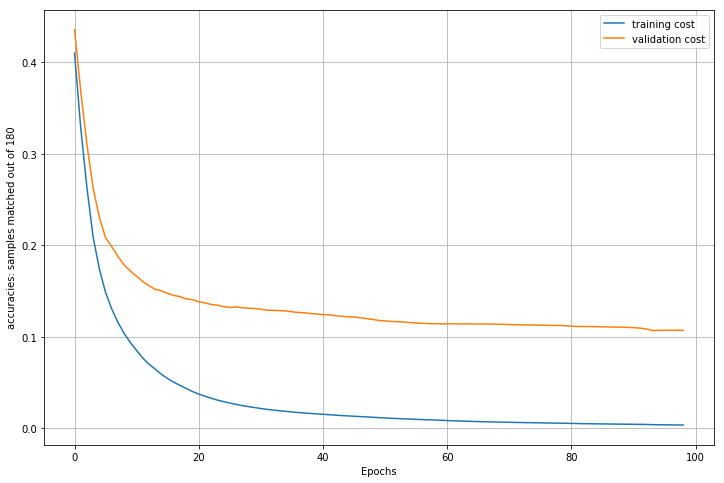

In [97]:
# plot early stopping
plt.figure(figsize=(12, 8))
plt.plot(t_cost, label="training cost")
plt.plot(e_cost, label="validation cost")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("accuracies: samples matched out of 180")
plt.legend(loc='best')
print("best epoch at {}".format(best_epoch))

## Observations Early stopping

In order to accelerate the learning process, learning rate was optimised to 0.2. With that a saturation of the cost of the evaluation data triggering the early stopping was reached after 940 epochs (see end of print-outs above).

In [98]:
# no retrain on training plus validation set using same settings, 
# performing the optimal step size
train_valid_set = train_set + valid_set
net = Network(layers)

t_cost, t_accuracy, e_cost, e_accuracy, i = net.SGD(train_valid_set, best_epoch, 50, 0.2, 
                validation_data=test_set,
                monitor_evaluation_cost=True,
                monitor_evaluation_accuracy=True,
                monitor_training_cost=True,
                monitor_training_accuracy=True)

Epoch 10 complete
Cost on training data: 0.810216022752413
Accuracy on training data: 160 / 1618
Cost on evaluation data: 0.8386586537752487
Accuracy on evaluation data: 17 / 179
Epoch 20 complete
Cost on training data: 0.7241369392864271
Accuracy on training data: 160 / 1618
Cost on evaluation data: 0.7450668283028573
Accuracy on evaluation data: 17 / 179
Epoch 30 complete
Cost on training data: 0.675014724335942
Accuracy on training data: 160 / 1618
Cost on evaluation data: 0.6942183400624707
Accuracy on evaluation data: 17 / 179
Epoch 40 complete
Cost on training data: 0.22466292764427834
Accuracy on training data: 1120 / 1618
Cost on evaluation data: 0.2553224827484004
Accuracy on evaluation data: 119 / 179
Epoch 50 complete
Cost on training data: 0.19438327022779214
Accuracy on training data: 1188 / 1618
Cost on evaluation data: 0.23183089666987425
Accuracy on evaluation data: 125 / 179
Epoch 60 complete
Cost on training data: 0.17098822971640631
Accuracy on training data: 1246 / 

Epoch 460 complete
Cost on training data: 0.011039992052824476
Accuracy on training data: 1607 / 1618
Cost on evaluation data: 0.09230314376763653
Accuracy on evaluation data: 156 / 179
Epoch 470 complete
Cost on training data: 0.010677188702803979
Accuracy on training data: 1607 / 1618
Cost on evaluation data: 0.09263922921520314
Accuracy on evaluation data: 157 / 179
Epoch 480 complete
Cost on training data: 0.010369960116747312
Accuracy on training data: 1607 / 1618
Cost on evaluation data: 0.09224974530270062
Accuracy on evaluation data: 158 / 179
Epoch 490 complete
Cost on training data: 0.009952775187420642
Accuracy on training data: 1609 / 1618
Cost on evaluation data: 0.092516654857603
Accuracy on evaluation data: 157 / 179
Epoch 500 complete
Cost on training data: 0.009567422834441557
Accuracy on training data: 1609 / 1618
Cost on evaluation data: 0.0912197661576418
Accuracy on evaluation data: 158 / 179
Epoch 510 complete
Cost on training data: 0.009303971327975738
Accuracy o

Accuracy on evaluation data: 162 / 179
Epoch 910 complete
Cost on training data: 0.004821560082512919
Accuracy on training data: 1611 / 1618
Cost on evaluation data: 0.08442423134806623
Accuracy on evaluation data: 162 / 179
Epoch 920 complete
Cost on training data: 0.004772782051334167
Accuracy on training data: 1611 / 1618
Cost on evaluation data: 0.08427634209351924
Accuracy on evaluation data: 162 / 179
Epoch 930 complete
Cost on training data: 0.004723436128459381
Accuracy on training data: 1611 / 1618
Cost on evaluation data: 0.08396040511544058
Accuracy on evaluation data: 162 / 179
Epoch 940 complete
Cost on training data: 0.004676646565904725
Accuracy on training data: 1611 / 1618
Cost on evaluation data: 0.08397931876736167
Accuracy on evaluation data: 162 / 179


## Retraining after Early stopping

Here the "valid_set" used as validation set for early stopping was merged with the training set in order to have all data available for training. A new run with the merged data was performed during the same optimal number of epochs, that was detected by early stopping. The model was then checked with the "test_set" not used at all so far.  

The test accuracy obtained was actually slightly better, than when running Early Stopping first on the Validation Data (162 / 179 samples instead of 158 / 180).

Virtually the same accuracy was achieved with L2 regularisation after only 300 epochs, and seemed to be still improving at this point. A combination of Early stopping and L2 regularisation with an optimal parameter would probably yield further improvement.  